# Loading ML Models with Different Data Types
Each model layer contains some weights that are going to be used for instance, meaning when we get the model's prediction. And each weight is stored usually as a matrix of learnable parameters, which can be represented in different precisions. Example a model having 12 layers and each weight in each layer has n parameters that are stored in 32-bit precision. Inspecting the model's data type is equivalent to inspecting the data type of model's weights.

In [1]:
import torch
import torch.nn as nn
import requests
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message=".*Using the model-agnostic default `max_length`.*")

In [2]:
class DummyModel(nn.Module):
  """
  This model consists of an embedding layer
  with two blocks of a linear layer followed by a layer
  norm layer.
  """
  def __init__(self):
    super().__init__()

    torch.manual_seed(123)

    self.token_embedding = nn.Embedding(2, 2)

    # Block 1
    self.linear_1 = nn.Linear(2, 2)
    self.layernorm_1 = nn.LayerNorm(2)

    # Block 2
    self.linear_2 = nn.Linear(2, 2)
    self.layernorm_2 = nn.LayerNorm(2)

    self.head = nn.Linear(2, 2)

  def forward(self, x):
    hidden_states = self.token_embedding(x)

    # Block 1
    hidden_states = self.linear_1(hidden_states)
    hidden_states = self.layernorm_1(hidden_states)

    # Block 2
    hidden_states = self.linear_2(hidden_states)
    hidden_states = self.layernorm_2(hidden_states)

    logits = self.head(hidden_states)
    return logits

## The Dummy Model
This is a simple Neural Network model defined using PyTorch.<br>
The **`super().__init__()`** Here init() method is the constructor of the class. It intializes various components of the model. The **super()** method in Python is used to call methods and access attributes of a parent or superclass within a subclass. Here it will call the init() method of the nn.Module class.<br>
The **`torch.manual_seed(123)`** sets the random seed to ensure reproducibility.<br>
**`self.token_embedding`** is an embedding layer with input size 2 and output size 2. This layer is used to convert input tokens into dense vectors.<br>
**`self.linear_1`** and **`self.layernorm_1`** are the first linear layer followed by a layer normalization layer for the first block.<br>
**`self.linear_2`** and **`self.layernorm_2`** are the second linear layer followed by a layer normalization layer for the second block.<br>
**`self.head`** is the final linear layer that produces the output logits.<br>
The **`forward`** method defines the forward pass of the model.<br>
**`hidden_states = self.token_embedding(x)`** embeds the input tokens x.<br>
**`Block 1`** applies linear transformation and layer normalization.<br>
**`Block 2`** applies another linear transformation and layer normalization.<br>
**`logits = self.head(hidden_states)`** produces the final output logits.<br>

In [3]:
model = DummyModel()
model

DummyModel(
  (token_embedding): Embedding(2, 2)
  (linear_1): Linear(in_features=2, out_features=2, bias=True)
  (layernorm_1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (linear_2): Linear(in_features=2, out_features=2, bias=True)
  (layernorm_2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=2, out_features=2, bias=True)
)

To check the data type of the model we will use a utility method from PyTorch called **`named_parameters()`** that we can call on a module to loop into each module's parameter and its name.

In [4]:
def print_param_dtype(model):
    for name, param in model.named_parameters():
        print(f"{name} is loaded in {param.dtype}")

In [5]:
print_param_dtype(model)

token_embedding.weight is loaded in torch.float32
linear_1.weight is loaded in torch.float32
linear_1.bias is loaded in torch.float32
layernorm_1.weight is loaded in torch.float32
layernorm_1.bias is loaded in torch.float32
linear_2.weight is loaded in torch.float32
linear_2.bias is loaded in torch.float32
layernorm_2.weight is loaded in torch.float32
layernorm_2.bias is loaded in torch.float32
head.weight is loaded in torch.float32
head.bias is loaded in torch.float32


We are able to print the model weight's name together with the data type of eeach weights. As we can see all the model weights are loaded in **FP32**.<br>
Now we will try to cast the weights into different dtypes. To convert it into **`bfloat16`** we can use **`model.half()`** or **`model.bfloat16()`** methods.

In [6]:
# float 16
model_fp16 = DummyModel().half()

In [7]:
print_param_dtype(model_fp16)

token_embedding.weight is loaded in torch.float16
linear_1.weight is loaded in torch.float16
linear_1.bias is loaded in torch.float16
layernorm_1.weight is loaded in torch.float16
layernorm_1.bias is loaded in torch.float16
linear_2.weight is loaded in torch.float16
linear_2.bias is loaded in torch.float16
layernorm_2.weight is loaded in torch.float16
layernorm_2.bias is loaded in torch.float16
head.weight is loaded in torch.float16
head.bias is loaded in torch.float16


We are defining a long tensor corresponding the IDs that we are going to pass to our transformer-like model as the first layer is an embedding layer which expects to have a long tensor as input and it will output the hidden states in floating point precisions. Here first we will try an inference using FP32 model then on FP16 model.

In [8]:
dummy_input = torch.LongTensor([[1, 0], [0, 1]])

In [9]:
# inference using float32 model
logits_fp32 = model(dummy_input)
logits_fp32

tensor([[[-0.6872,  0.7132],
         [-0.6872,  0.7132]],

        [[-0.6872,  0.7132],
         [-0.6872,  0.7132]]], grad_fn=<ViewBackward0>)

In [10]:
# inference using float16 model
try:
    logits_fp16 = model_fp16(dummy_input)
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

 RuntimeError :  "LayerNormKernelImpl" not implemented for 'Half' 


The reason it fails on FP16 is that some CPU kernels are not implemented for FP16. One of the disadvantages with PyTorch, FP16 and CPU is that for most of the transformer-based models, we are not able to use these models out of the box in FP16.<br>
One way to overcome this issue is instead of loading the model in FP16 we can also load it in BFP16 and perform inference.

In [11]:
from copy import deepcopy
model_bf16 = deepcopy(model)

We are creating a copy of the model using deepcopy so that we have same weights across the BF16 and FP32 models.

In [12]:
model_bf16 = model_bf16.to(torch.bfloat16)

In [13]:
print_param_dtype(model_bf16)
logits_bf16 = model_bf16(dummy_input)

token_embedding.weight is loaded in torch.bfloat16
linear_1.weight is loaded in torch.bfloat16
linear_1.bias is loaded in torch.bfloat16
layernorm_1.weight is loaded in torch.bfloat16
layernorm_1.bias is loaded in torch.bfloat16
linear_2.weight is loaded in torch.bfloat16
linear_2.bias is loaded in torch.bfloat16
layernorm_2.weight is loaded in torch.bfloat16
layernorm_2.bias is loaded in torch.bfloat16
head.weight is loaded in torch.bfloat16
head.bias is loaded in torch.bfloat16


Now we can compare the difference between **`logits_fp32`** and **`logits_bf16`**.

In [14]:
mean_diff = torch.abs(logits_bf16 - logits_fp32).mean().item()
max_diff = torch.abs(logits_bf16 - logits_fp32).max().item()

print(f"Mean diff: {mean_diff} | Max diff: {max_diff}")

Mean diff: 0.000997886061668396 | Max diff: 0.0016907453536987305


The difference is quite small, in practice this doesnt really lead to a huge performance degredation even for large models. So casting the model from FP32 to BF16 is most of the time performance cost-free.

## Loading Popular Generative Models in Different Data Types

In [15]:
from transformers import BlipForConditionalGeneration

In [16]:
model_name = "Salesforce/blip-image-captioning-base"

In [17]:
model = BlipForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
print_param_dtype(model)

vision_model.embeddings.class_embedding is loaded in torch.float32
vision_model.embeddings.position_embedding is loaded in torch.float32
vision_model.embeddings.patch_embedding.weight is loaded in torch.float32
vision_model.embeddings.patch_embedding.bias is loaded in torch.float32
vision_model.encoder.layers.0.self_attn.qkv.weight is loaded in torch.float32
vision_model.encoder.layers.0.self_attn.qkv.bias is loaded in torch.float32
vision_model.encoder.layers.0.self_attn.projection.weight is loaded in torch.float32
vision_model.encoder.layers.0.self_attn.projection.bias is loaded in torch.float32
vision_model.encoder.layers.0.layer_norm1.weight is loaded in torch.float32
vision_model.encoder.layers.0.layer_norm1.bias is loaded in torch.float32
vision_model.encoder.layers.0.mlp.fc1.weight is loaded in torch.float32
vision_model.encoder.layers.0.mlp.fc1.bias is loaded in torch.float32
vision_model.encoder.layers.0.mlp.fc2.weight is loaded in torch.float32
vision_model.encoder.layers.0.m

To get the memory footprint (how much memory is required in MBs, GBs, etc) of the model we can use the **`model.get_memory_footprint()`** method.

In [19]:
fp32_mem_footprint = model.get_memory_footprint()

In [20]:
print("Footprint of the fp32 model in bytes: ", fp32_mem_footprint)
print("Footprint of the fp32 model in MBs: ", fp32_mem_footprint/1e+6)

Footprint of the fp32 model in bytes:  989660400
Footprint of the fp32 model in MBs:  989.6604


### Load the model in differnt precisions
To load the model in different precision just pass the parameter **`torch_dtpye`** inside the **`from_pretrained()`** function.

In [21]:
# Loading the same model in BF16
model_bf16 = BlipForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.bfloat16)

In [22]:
bf16_mem_footprint = model_bf16.get_memory_footprint()

In [23]:
# Get the relative difference
relative_diff = bf16_mem_footprint / fp32_mem_footprint

print("Footprint of the bf16 model in MBs: ", bf16_mem_footprint/1e+6)
print(f"Relative diff: {relative_diff}")

Footprint of the bf16 model in MBs:  494.832248
Relative diff: 0.5000020693967345


The model's size is reduced to half the original size.

### Comparing the FP32 and BF16 Model's Performance

In [24]:
from transformers import BlipProcessor
processor = BlipProcessor.from_pretrained(model_name)

In [25]:
def get_generation(model, processor, image, dtype):
  inputs = processor(image, return_tensors="pt").to(dtype)
  out = model.generate(**inputs)
  return processor.decode(out[0], skip_special_tokens=True)


def load_image(img):
    image = Image.open(img).convert('RGB')
    return image

**`load_image(img_url)`** function takes an image as input, opens the image as a PIL (Python Imaging Library) image, and converts it to RGB format. The function then returns the loaded image.<br>
**`get_generation(model, processor, image, dtype)`** function takes four inputs: a pre-trained language model **(model)**, a processor for the model **(processor)**, an image **(loaded using the load_image function)**, and a data type **(dtype)**. The function first processes the image using the provided processor and converts it to the specified data type (dtype). It then uses the processed image as input to the **`model.generate()`** method to generate text based on the content of the image. The generated text is decoded using the **`processor.decode()`** method, which skips special tokens, and the decoded text is returned as the output of the function.

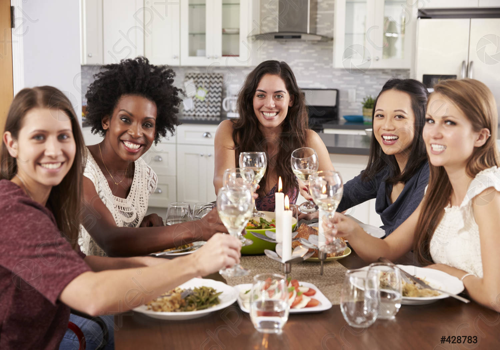

In [26]:
from IPython.display import display

image = load_image('dinner.jpg')
display(image.resize((500, 350)))

In [27]:
results_fp32 = get_generation(model,
                              processor,
                              image,
                              torch.float32)

In [28]:
print("fp32 Model Results:\n", results_fp32)

fp32 Model Results:
 a group of women sitting around a table eating


In [29]:
results_bf16 = get_generation(model_bf16,
                              processor,
                              image,
                              torch.bfloat16)

In [30]:
print("bf16 Model Results:\n", results_bf16)

bf16 Model Results:
 a group of women sitting around a table eating


In both cases the results seems pretty similar and accurate. The reason it can affected the generated token here is that all the errors between the FP32 logits and the BF16 logits get accumulated across layers and layers and since the model is an **auto-regressive model** ( means it uses the results of the previous iteration) all these erros get accumulated until at some point impacting the model's prediction.<br>
Overall it doesn't affects the performace, we can use BF16 on CPU and FP16 on GPU.

Uptill now we were loading the model in FP32 and then casting it into BF16 but this can be an issue in practice, in production. Beacuse we have to load bigger model first and then cast it into our desired dtype, this process can be performed directly to save memory. We can do this by using the **`.set_default_dtype()`** method from PyTorch which will set the default dtype, so when we load the model it will get loaded in the desired dtype.

In [31]:
desired_dtype = torch.bfloat16
torch.set_default_dtype(desired_dtype)

In [32]:
dummy_model_bf16 = DummyModel()

In [33]:
print_param_dtype(dummy_model_bf16)

token_embedding.weight is loaded in torch.bfloat16
linear_1.weight is loaded in torch.bfloat16
linear_1.bias is loaded in torch.bfloat16
layernorm_1.weight is loaded in torch.bfloat16
layernorm_1.bias is loaded in torch.bfloat16
linear_2.weight is loaded in torch.bfloat16
linear_2.bias is loaded in torch.bfloat16
layernorm_2.weight is loaded in torch.bfloat16
layernorm_2.bias is loaded in torch.bfloat16
head.weight is loaded in torch.bfloat16
head.bias is loaded in torch.bfloat16
